In [70]:
%load_ext memory_profiler
# %matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib
import os
from fits_reader import shelf,fits_reader
import importlib
import glob
import spec_reader


importlib.reload(fits_reader)
importlib.reload(spec_reader)
importlib.reload(spec_reader.irradiance)
importlib.reload(spec_reader.angle_function)
importlib.reload(shelf)

import gc
import math
import sys
import numpy as np


The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [71]:

home_directory = os.environ['HOME']
datadirectory = home_directory + '/spectrometer/wsmr_measurement/20210528_WSMR1/'
d = "0mm"
measuredFiles = glob.glob(datadirectory + d +"*")
bgFiles = glob.glob(datadirectory +"BG_"+ d+"*")
# print(spec_reader.__path__)
matsumi_baffle = spec_reader.angle_function.BaffleClass('sp1_40deg_kiwami.csv','sp1_base_20210401.csv')
ls_irradiance_class= spec_reader.irradiance.IrradianceClass(measuredFiles,bgFiles,matsumi_baffle)
arms = ["armS","armM","armL"]
home_directory = os.environ['HOME']
season_name = "/WSMR2021May/reduction/2021-06-23"
experiment_name = "/abs_calib/vis/"
experiment_directory = home_directory + season_name + experiment_name
eps_shelf = shelf.make_reduction_shelf(experiment_directory)



<img src="./img/10_CF/CIBER2_config.png" width="500">


In [57]:
OD = "OD1"
arm_name = "armS"
cf_class = spec_reader.irradiance.CF_Class(eps_shelf,ls_irradiance_class,OD,arm_name)

/home/ciber2/python/main/calibration/fits_reader/shelf.py:81: RuntimeWarning: Mean of empty slice
  img = np.nanmean(imgs,axis=0)


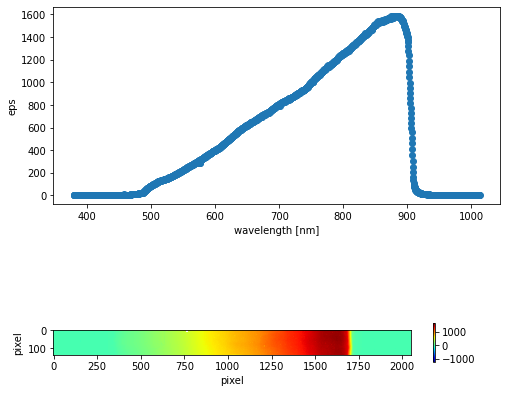

In [69]:
fig,axs = plt.subplots(2,1)

waves_lvf, eps_lvf = cf_class.get_wv_vs_eps_at_lvf()
ax = axs[0]
ax.scatter(waves_lvf, eps_lvf)
ax.set_xlabel("wavelength [nm]")
ax.set_ylabel("eps")

ax = axs[1]
img = cf_class.get_LVF_img()
ax.imshow(img)
ax.set_xlabel("pixel")
ax.set_ylabel("pixel")
im = ax.imshow(img,cmap = 'jet')
fig.colorbar(im,ax = ax,shrink=0.2)
fig.set_size_inches(8,8)

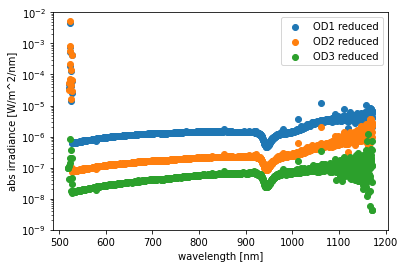

In [8]:
ODs = ["OD1","OD2","OD3"]
cf_classes = {}
arm_name = "armS"
fig,ax = plt.subplots()
for OD in ODs:
    cf_classes[OD] = spec_reader.irradiance.CF_Class(eps_shelf,ls_irradiance_class,OD,arm_name)
for OD in ODs:
    cf_class = cf_classes[OD]
    ax.scatter(cf_class.waves_spec,cf_class.ls_irradinance_reduced,label= OD+" reduced")
ax.legend()
ax.set_xlabel("wavelength [nm]")
ax.set_ylabel("abs irradiance [W/m^2/nm]")
ax.set_ylim(1*10**-9,0.01)
ax.set_yscale("log")

# compare ND filter measurement
① CIBER2<img src="./img/10_CF/CIBER2_config.png" width="500">
② spectrometer<img src="./img/10_CF/spec_config.png" width="250">

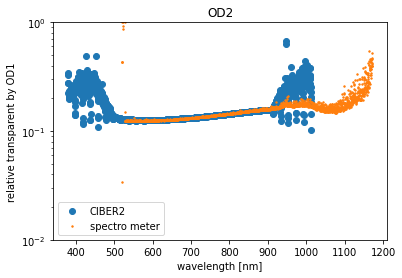

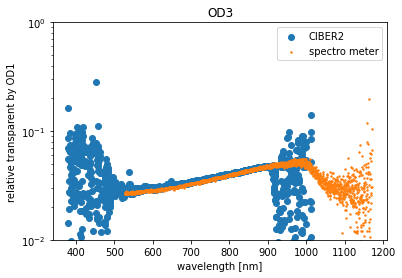

In [20]:
cf_class_base = cf_classes["OD1"]
for OD in ODs[1:]:
    fig,ax = plt.subplots()
    cf_class = cf_classes[OD]
    transparent = cf_class.eps_lvf/cf_class_base.eps_lvf
    ax.scatter(cf_class.waves_lvf,transparent,label="CIBER2")
    
    transparent_fiber = cf_class.get_ND()[1]/cf_class_base.get_ND()[1]
    ax.scatter(cf_class.waves_spec,transparent_fiber,label="spectrometer", s=2)
    ax.legend()
    ax.set_xlabel("wavelength [nm]")
    ax.set_ylabel("relative transparent by OD1")
    ax.set_ylim(1*10**-2,1)
    ax.set_title(OD)
    ax.set_yscale("log")

(500.0, 950.0)

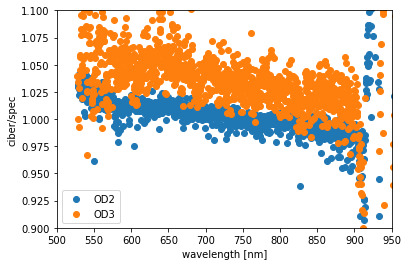

In [22]:
from scipy import interpolate

cf_class_base = cf_classes["OD1"]
fig,ax = plt.subplots()
x =cf_class.waves_spec

for OD in ODs[1:]:
    cf_class = cf_classes[OD]
    transparent_ciber = cf_class.eps_lvf/cf_class_base.eps_lvf
    transparent_ciber_ip_to_spec = interpolate.interp1d(cf_class.waves_lvf,transparent_ciber,fill_value="extrapolate")(x)

    transparent_fiber = cf_class.get_ND()[1]/cf_class_base.get_ND()[1]
    ax.scatter(x,transparent_ciber_ip_to_spec/transparent_fiber,label=OD)
ax.legend()
ax.set_xlabel("wavelength [nm]")
ax.set_ylabel("ciber/spec")
ax.set_ylim(0.9,1.1)
ax.set_xlim(500,950)


Text(0, 0.5, 'CF[radiance/eps]')

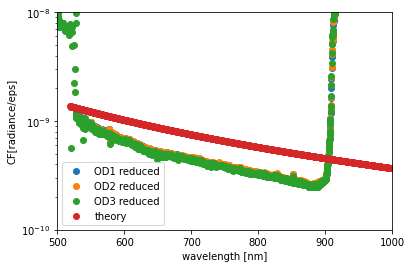

In [18]:
fig,ax = plt.subplots()
for OD in ODs:
    cf_class = cf_classes[OD]
    ax.scatter(cf_class.waves_lvf,cf_class.cf,label= OD+" reduced")
    
w,cf= spec_reader.irradiance.get_cf_from_theory()
ax.scatter(w,cf,label= "theory")

ax.legend()
ax.set_xlim(500,1000)
ax.set_ylim(10**-10,10**-8)
ax.set_yscale("log")
ax.set_xlabel("wavelength [nm]")
ax.set_ylabel("CF[radiance/eps]")

In [19]:
cf_set = []
for OD in ODs:
    cf_class = cf_classes[OD]
    cf_set.append(cf_class.cf)

cf_set_np = np.array(cf_set)
cf_average = np.average(cf_set_np,axis = 0)

Text(0, 0.5, 'CF/CF average')

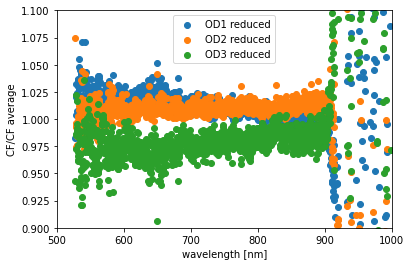

In [20]:
fig,ax = plt.subplots()
for OD in ODs:
    cf_class = cf_classes[OD]
    ax.scatter(cf_class.waves_lvf,cf_class.cf/cf_average,label= OD+" reduced")

ax.legend()
ax.set_xlim(500,1000)
ax.set_ylim(0.9,1.1)
# ax.set_yscale("log")
ax.set_xlabel("wavelength [nm]")
ax.set_ylabel("CF/CF average")